# 基本信息
1. 实验名称：实验4 卷积神经网络实验
2. 姓名：
3. 学号：
4. 日期：2022年12月10日

> 数据集为车辆分类数据和照片去雾数据

# 一、 二维卷积实验


## 手动实现卷积网络

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

In [ ]:
def corr2d(X, K):
    H, W = X.shape
    k_h, k_w = K.shape
    Y = torch.zeros(size=(H - k_h + 1, W - k_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i+k_h, j:j+k_w] * K).sum()
    return Y

In [ ]:
X = torch.tensor(data = [i for i in range(9)])
X = X.reshape(3,3)
K = torch.tensor([[0, 1], [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, X):
        return corr2d(X, self.weight) + self.bias

In [ ]:
def comp_conv2d(conv2d, X):
    X = X.view((1, 1) + X.shape)
    Y = conv2d(X)
# ignore first 2 dim batch_size, channel
    return Y.view(Y.shape[2:])

In [ ]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=2)
X = torch.rand(8, 8)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
def corr2d_multi_in(X, K):
    # multi-channel corr2d
    # input shape like (C, H, W)
    res = corr2d(X[0, :, :], K[0, :, :])
    for i in range(1, X.shape[0]):
        res += corr2d(X[i, :, :], K[i, :, :])
    return res

In [ ]:
X = torch.tensor([[i for i in range(9)],
                  [i for i in range(1, 10)]])
K = torch.tensor([[i for i in range(4)],
                  [i for i in range(1, 5)]])
X = X.reshape(2, 3, 3)
K = K.reshape(2, 2, 2)

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [ ]:
def corr2d_multi_in_out(X, K):
    # 0 dim of K is num of kernel, should be traversed
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=1)

In [ ]:
# X.shape (channel_in, H, W)
# K.shape (C_out, C_in, H, W)
X = torch.arange(192, dtype=torch.float32).view((3, 8, 8))
K  = torch.arange(108, dtype=torch.float32).view((4, 3, 3, 3))

Y = corr2d_multi_in_out(X, K)
print("kernel shape", K.shape)
print("Y shape", Y.shape)

kernel shape torch.Size([4, 3, 3, 3])
Y shape torch.Size([6, 4, 6])


In [ ]:
def pool2d(X, pool_size, mode='max'):
    X = X.float()
    p_h, p_w = pool_size
    Y = torch.zeros(X.shape[0] - p_h +1, X.shape[1] - p_w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode=='max':
                Y[i, j] = X[i: i+p_h, j:j+p_w].max()
            elif mode=='avg':
                Y[i, j] = X[i:i+p_h, j:j+p_w].mean()
    return Y

In [ ]:
X = torch.tensor([i for i in range(9)]).reshape(3,3)

print("max pool")
print(pool2d(X, (2, 2)))
print("avg pool")
print(pool2d(X, (2, 2), 'avg'))

max pool
tensor([[4., 5.],
        [7., 8.]])
avg pool
tensor([[2., 3.],
        [5., 6.]])


In [ ]:
class MyConv2D(nn.Module):
    def __init__(self, in_channels,  out_channels, kernel_size):
        super(MyConv2D, self).__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn(size=(out_channels, in_channels) + kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels, 1, 1))

    def corr2d(self, X, K):
        """

        :param X: shape batch_size, H, W
        :param K: shape k_h, k_w
        :return:  single channel
        """
        batch_size, H, W = X.shape
        k_h, k_w = K.shape
        Y = torch.zeros((batch_size, H- k_h+1, W-k_w+1)).cuda()
        for i in range(Y.shape[1]):
            for j in range(Y.shape[2]):
                Y[:, i, j] = (X[:, i:i+k_h, j:j+k_w]*K).sum(dim=2).sum(dim=1)
        return Y

    def corr2d_multi_in(self, X, K):
        """

        :param X: shape batch_size, C_in, H, W
        :param K: shape C_in, k_h, k_w
        :return:    shape batch_size, H_out, W_out
        """
        res = self.corr2d(X[:, 0, :, :], K[0, :, :])
        for i in range(1, X.shape[1]):
            res += self.corr2d(X[:, i, :,:], K[i, :, :])
        return res

    def corr2d_multi_in_out(self, X, K):
        """

        :param X: shape batch_size, C_in, H, W
        :param K: shape C_out, C_in, k_h, K_w
        :return: shape batch_size, C_out, H_out, W_out
        """
        return torch.stack([self.corr2d_multi_in(X, k) for k in K], dim=1)

    def forward(self, X):
        # print(X.is_cuda)
        # print(self.weight.is_cuda)
        # print(self.bias.is_cuda)
        return self.corr2d_multi_in_out(X, self.weight) + self.bias

## 数据集的准备

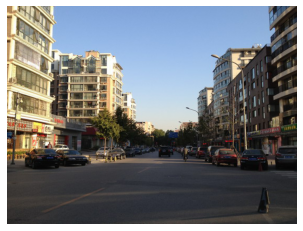

(100, 200, 3)


D:\Anaconda3_2022.05\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()


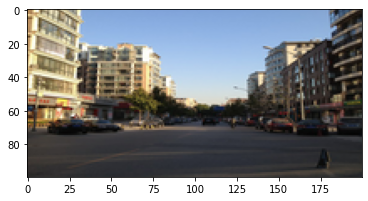

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

file = "../Datasets/去雾数据集/去雾图片/001.jpg"
img  = Image.open(file)
plt.imshow(img)
plt.axis("off")
plt.show()

img = img.resize((200, 100), Image.ANTIALIAS)
img = np.array(img)
print(img.shape)
img = img/255
plt.imshow(img)


In [ ]:
import os
import random
import time
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:

file_path = "../Datasets/车辆分类数据集"

dirs = os.listdir(file_path)
nums = []
for i in range(len(dirs)):
    subdir = file_path + "//" + dirs[i]
    nums.append(len(os.listdir(subdir)))
print(nums)

[219, 779, 360]


In [ ]:
def read_data(path):
    file_name = os.listdir(path)
    nums = []
    for i in range(len(file_name)):
        subdir = path + "//" + file_name[i]
        nums.append(len(os.listdir(subdir)))

    train_data = []
    train_labels = []
    test_data = []
    test_labels = []


    train_num = [int (num * 4/5) for num in nums]
    test_num = [nums[i] - train_num[i] for i in range(len(nums))]
    print(train_num, test_num)

    for idx, name in enumerate(file_name):
        im_dirs = path + "/" + name
        im_path = os.listdir(im_dirs)

        index = list(range(len(im_path)))
        random.shuffle(index)

        im_path_ = list(np.array(im_path)[index])

        train_path = im_path_[test_num[idx] :]
        test_path = im_path_[:test_num[idx]]
        for img_name in train_path:
            if img_name == "desktop.ini":
                continue
            img = Image.open(im_dirs + "/" + img_name)
            train_data.append(img)
            train_labels.append(idx)
        for img_name in test_path:
            if img_name == "desktop.ini":
                continue
            img = Image.open(im_dirs + '/' + img_name)
            test_data.append(img)
            test_labels.append(idx)

    print("len of train data", len(train_data), " len of test data", len(test_data))
    return train_data, train_labels, test_data, test_labels

In [ ]:
file_path = "./车辆分类数据集"
train_data, train_labels,  test_data, test_labels = read_data(file_path)

[288, 175, 623] [72, 44, 156]
len of train data 1085  len of test data 272


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

class MyDateset(torch.utils.data.Dataset):
    def __init__(self, data, label, trans):
        self.len = len(data)
        self.data = data
        self.label = label
        self.trans = trans

    def __getitem__(self, item):
        return self.trans(self.data[item]), self.label[item]

    def __len__(self):
        return self.len



## 训练函数、评价函数的定义

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum = (net.predict(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    result = y_hat.type(y.dtype) == y
    # op== is very sensitive with data type, so call tensor.type() to stay the same with y
    return float(result.type(y.dtype).sum())/len(y)

def eval_test(net, data_iter, loss):
    result = []
    l = 0.0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.cuda()
            y = y.cuda()
            y_hat = net.forward(X)
            l += loss(y_hat, y).mean()
            result.append(accuracy(y_hat, y))
    return np.array(result).mean(), (l/len(result)).cpu()



def train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer,name_net, debug=False):
    train_loss_ls = []
    test_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    start_t = 0.0
    end_t = 0.0
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m)== MyConv2D:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    for epoch in range(epochs):
        l_sum = 0.0
        num = 0
        acc =0.0
        start_t = time.time()
        for X, y in train_loader:

            X = X.cuda()
            y = y.cuda()

            y_hat = net.forward(X)
            if debug:
                print("y_hat shape", y_hat.shape)
                print("y shape", y.shape)
            l = loss(y_hat, y)

        acc += accuracy(y_hat, y)

        # if type(optimizer) == torch.optim.Optimizer:
        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
        # else:
        #   l.sum().backward()
        #   optimizer([W, b], lr, batch_size)
        l_sum += l.sum()/ y.shape[0]
        num+=1

        # need to be summed

        with torch.no_grad():

            train_loss = (l_sum/num).cpu()
            test_acc, test_loss = eval_test(net, test_loader, loss)
            train_loss_ls.append(train_loss)
            acc_train_ls.append((acc/num))
            acc_test_ls.append(test_acc) # have gain mean
            test_loss_ls.append(test_loss)

            end_t = time.time()
            total_time = end_t-start_t
            print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num),  "test_loss", "%.4f" %test_loss, "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc, "time_cost","%.4f"%total_time)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(test_loss_ls, label='test_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

## 手动实现卷积层的结果

epochs 1 train_loss 0.5813 test_loss 10.9483 train_acc 1.0000 test_acc 0.4792 time_cost 138.2359
epochs 2 train_loss 0.0000 test_loss 10.9483 train_acc 1.0000 test_acc 0.4792 time_cost 202.5379


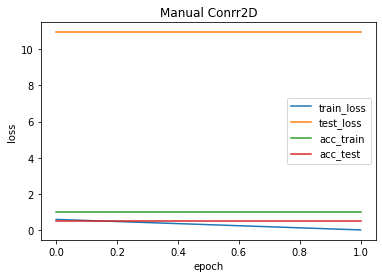

In [ ]:
epochs = 2
lr = 0.01
batch_size = 128
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    MyConv2D(3, 6, 5),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    MyConv2D(6, 16, 5),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 144, 512), nn.ReLU(),
    nn.Linear(512, 144), nn.ReLU(),
    nn.Linear(144, 3)).cuda()

train_dataset = MyDateset(train_data, train_labels, transform)
test_dataset = MyDateset(test_data, test_labels, transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = torch.optim.SGD(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "Manual Conrr2D")

可以看出，手动实现的CNN实现成功。但是效果不是太好，应该是超参数设定的不太好，对特征提取的效果不好，导致在测试集上的结果不好。就测试集上的loss，与使用torch.nn实现的CNN相比要更大，应该是参数初始化方式不同导致。

## torch.nn实现卷积层

epochs 1 train_loss 1.0907 test_loss 1.0742 train_acc 0.0000 test_acc 0.4062 time_cost 0.8168
epochs 2 train_loss 1.0759 test_loss 1.0716 train_acc 0.0000 test_acc 0.3958 time_cost 0.9562
epochs 3 train_loss 1.0615 test_loss 1.0691 train_acc 0.0328 test_acc 0.4688 time_cost 0.5762
epochs 4 train_loss 1.0474 test_loss 1.0668 train_acc 0.8689 test_acc 0.4792 time_cost 0.4700
epochs 5 train_loss 1.0336 test_loss 1.0645 train_acc 1.0000 test_acc 0.4792 time_cost 0.4794


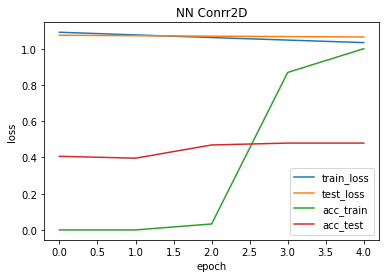

In [ ]:
epochs = 5
lr = 0.01
batch_size = 128
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net1 = nn.Sequential(
    nn.Conv2d(3, 6, 5, stride=1, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(6, 16, 5, stride=1, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 144, 512), nn.ReLU(),
    nn.Linear(512, 144), nn.ReLU(),
    nn.Linear(144, 3)).cuda()

train_dataset = MyDateset(train_data, train_labels, transform)
test_dataset = MyDateset(test_data, test_labels, transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = torch.optim.SGD(net1.parameters(), lr)
train_corr2d(net1, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

使用torch.nn实现的CNN效果也不是很好，网络的更新速度比手动实现的慢一些，在测试集上准确度的最终结果是一样的。

## 更改超参数进行对比实验

epochs 1 train_loss 1.3944 test_loss 1.9206 train_acc 0.0000 test_acc 0.4792 time_cost 1.6006
epochs 2 train_loss 0.1215 test_loss 4.3023 train_acc 1.0000 test_acc 0.4792 time_cost 0.6044
epochs 3 train_loss 0.0033 test_loss 6.9682 train_acc 1.0000 test_acc 0.4792 time_cost 0.5947
epochs 4 train_loss 0.0001 test_loss 9.6736 train_acc 1.0000 test_acc 0.4792 time_cost 0.5999
epochs 5 train_loss 0.0000 test_loss 12.3491 train_acc 1.0000 test_acc 0.4792 time_cost 0.6003


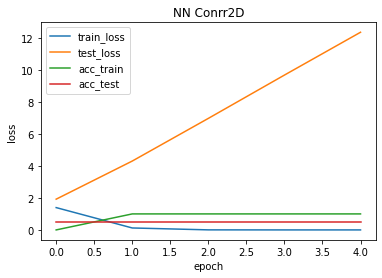

In [ ]:
# 修改 lr 对比
epochs = 5
lr = 0.001
batch_size = 128
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net2 = nn.Sequential(
    nn.Conv2d(3, 6, 5, stride=1, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(6, 16, 5, stride=1, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 144, 512), nn.ReLU(),
    nn.Linear(512, 144), nn.ReLU(),
    nn.Linear(144, 3)).cuda()

train_dataset = MyDateset(train_data, train_labels, transform)
test_dataset = MyDateset(test_data, test_labels, transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = torch.optim.Adam(net2.parameters(), lr)
train_corr2d(net2, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

可以看出lr变小之后，收敛速度变慢，最终的模型效果是一样的。

epochs 1 train_loss 0.7933 test_loss 2.5714 train_acc 1.0000 test_acc 0.6094 time_cost 4.3988
epochs 2 train_loss 0.0232 test_loss 5.3592 train_acc 1.0000 test_acc 0.6094 time_cost 0.5189
epochs 3 train_loss 0.0003 test_loss 8.4760 train_acc 1.0000 test_acc 0.6094 time_cost 0.5047
epochs 4 train_loss 0.0000 test_loss 11.7654 train_acc 1.0000 test_acc 0.6094 time_cost 0.4879
epochs 5 train_loss 0.0000 test_loss 15.1328 train_acc 1.0000 test_acc 0.6094 time_cost 0.4927


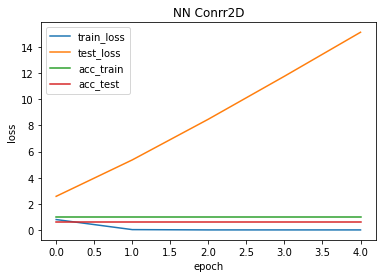

In [ ]:
# 增大 batch_size
epochs = 5
lr = 0.001
batch_size = 256
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 6, 5, stride=1, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(6, 16, 5, stride=1, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 144, 512), nn.ReLU(),
    nn.Linear(512, 144), nn.ReLU(),
    nn.Linear(144, 3)).cuda()

train_dataset = MyDateset(train_data, train_labels, transform)
test_dataset = MyDateset(test_data, test_labels, transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

可以看出，增大batch_size对模型最终效果有帮助，在测试集上表现变好。但是考虑到模型相对于数据集来说还是比较复杂，过拟合现象严重，test_loss后边甚至开始上升了。

epochs 1 train_loss 1.8823 test_loss 1.1416 train_acc 0.0000 test_acc 0.3516 time_cost 1.7176
epochs 2 train_loss 1.1802 test_loss 0.9665 train_acc 0.1639 test_acc 0.6250 time_cost 0.9031
epochs 3 train_loss 0.7547 test_loss 0.9544 train_acc 0.9672 test_acc 0.6094 time_cost 1.0387
epochs 4 train_loss 0.4913 test_loss 1.0460 train_acc 1.0000 test_acc 0.6094 time_cost 0.5680
epochs 5 train_loss 0.3072 test_loss 1.2029 train_acc 1.0000 test_acc 0.6094 time_cost 0.8234


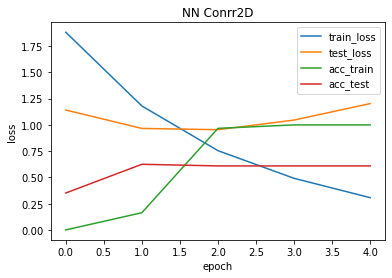

In [ ]:
# 改变卷积层数对比
epochs = 5
lr = 0.001
batch_size = 256
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 10, 3, stride=3, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(10* 100, 25), nn.ReLU(),
    nn.Linear(25, 3)).cuda()
train_dataset = MyDateset(train_data, train_labels, transform)
test_dataset = MyDateset(test_data, test_labels, transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

可以看出在减少一个卷积层块和一个全连接层后并且把剩下的一个卷积层的输出通道数减少。这样的模型过拟合现象有所缓和，test_loss也是在下降的，test_acc有上升的过程。

epochs 1 train_loss 1.5239 test_loss 1.0952 train_acc 0.0000 test_acc 0.2734 time_cost 1.3554
epochs 2 train_loss 1.1067 test_loss 0.9770 train_acc 0.3279 test_acc 0.6133 time_cost 0.5469
epochs 3 train_loss 0.8327 test_loss 0.9385 train_acc 0.9508 test_acc 0.6094 time_cost 0.5000
epochs 4 train_loss 0.6321 test_loss 0.9536 train_acc 1.0000 test_acc 0.6094 time_cost 0.5632
epochs 5 train_loss 0.4647 test_loss 1.0317 train_acc 1.0000 test_acc 0.6094 time_cost 0.5000


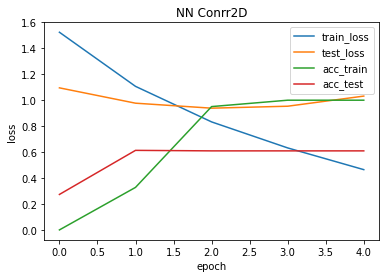

In [ ]:
# 改变卷积核大小
epochs = 5
lr = 0.001
batch_size = 256
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 10, 5, stride=3, padding=0),
    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(10* 100, 25), nn.ReLU(),
    nn.Linear(25, 3)).cuda()
train_dataset = MyDateset(train_data, train_labels, transform)
test_dataset = MyDateset(test_data, test_labels, transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

可以看出通过增大卷积核大小，在本次实验中，对最终acc没有影响，但是loss产生了一系列的波动，test_loss比卷积核为3*3是要大。可以认为卷积核大取的颗粒度更大，特征提取会有一定差异。

# 二、 空洞卷积实验

## 基本空洞卷积实验结果

epochs 1 train_loss 0.7295 test_loss 0.9693 train_acc 0.7213 test_acc 0.5586 time_cost 1.0557
epochs 2 train_loss 0.6462 test_loss 0.9567 train_acc 0.7377 test_acc 0.5430 time_cost 0.5312
epochs 3 train_loss 0.5701 test_loss 0.9506 train_acc 0.8361 test_acc 0.5625 time_cost 0.5157
epochs 4 train_loss 0.5005 test_loss 0.9490 train_acc 0.9016 test_acc 0.5918 time_cost 0.4843
epochs 5 train_loss 0.4370 test_loss 0.9528 train_acc 0.9508 test_acc 0.5859 time_cost 0.5001


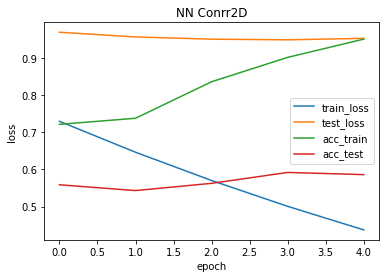

In [ ]:
epochs = 5
lr = 0.001
batch_size = 256
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 2, 3, stride=2, dilation=1),
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 4, 3, dilation=2, stride=2),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.Conv2d(4, 8, 3, dilation=5),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8 * 16, 25), nn.ReLU(),
    nn.Linear(25, 3)).cuda()

optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

由于第一部分的卷积实验层数和空洞卷积实验不一样，不能进行对比。这里按照空洞卷积网络参数构建一个普通卷积网络进行对比。

## 实验对比

epochs 1 train_loss 0.9815 test_loss 1.1510 train_acc 0.6230 test_acc 0.5410 time_cost 0.7201
epochs 2 train_loss 0.6746 test_loss 1.1064 train_acc 0.7869 test_acc 0.5645 time_cost 0.7976
epochs 3 train_loss 0.4870 test_loss 1.0901 train_acc 0.9344 test_acc 0.5898 time_cost 0.6744
epochs 4 train_loss 0.3696 test_loss 1.0931 train_acc 0.9672 test_acc 0.5820 time_cost 0.5781
epochs 5 train_loss 0.2875 test_loss 1.1114 train_acc 0.9836 test_acc 0.5820 time_cost 0.6736


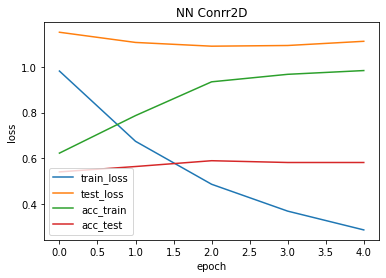

In [ ]:
epochs = 5
lr = 0.001
batch_size = 256
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 2, 3, stride=2),
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 4, 5, stride=2),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.Conv2d(4, 8, 11),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8 * 16, 25), nn.ReLU(),
    nn.Linear(25, 3)).cuda()

optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

卷积模型的参数对比应该对核大小进行对应设置，其中第一层仍为3，第二层变为5，第三层为11，其他参数不变。通过对比，我们可以发现，空洞模型相比卷积模型，训练时间变短，对训练集的拟合变弱，acc变低，loss变大。这是因为参数量减少。同时，发现过拟合现象有一定程度的缓解，在测试集上的表现变好。

epochs 1 train_loss 1.6287 test_loss 1.1677 train_acc 0.0820 test_acc 0.4941 time_cost 0.9603
epochs 2 train_loss 0.5830 test_loss 1.4518 train_acc 0.8852 test_acc 0.6094 time_cost 0.7350
epochs 3 train_loss 0.2350 test_loss 2.0485 train_acc 1.0000 test_acc 0.6094 time_cost 0.5468
epochs 4 train_loss 0.0994 test_loss 2.7791 train_acc 1.0000 test_acc 0.6094 time_cost 0.6580
epochs 5 train_loss 0.0347 test_loss 3.5541 train_acc 1.0000 test_acc 0.6094 time_cost 0.6249


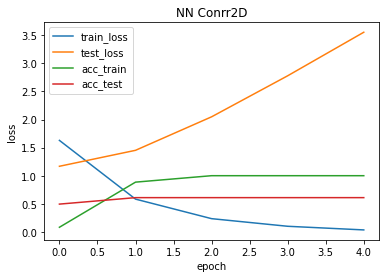

In [ ]:
# 增大lr
pochs = 5
lr = 0.01
batch_size = 256
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 2, 3, stride=2, dilation=1),
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 4, 3, dilation=2, stride=2),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.Conv2d(4, 8, 3, dilation=5),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8 * 16, 25), nn.ReLU(),
    nn.Linear(25, 3)).cuda()

optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

可以看出lr的增大，加快了模型收敛，同时也把最终的过拟合程度完全的表现出来

epochs 1 train_loss 1.7362 test_loss 1.5868 train_acc 0.0820 test_acc 0.1953 time_cost 0.9741
epochs 2 train_loss 1.5322 test_loss 1.4801 train_acc 0.1148 test_acc 0.2227 time_cost 0.9487
epochs 3 train_loss 1.3443 test_loss 1.3903 train_acc 0.2131 test_acc 0.3125 time_cost 0.5469
epochs 4 train_loss 1.1750 test_loss 1.3165 train_acc 0.3279 test_acc 0.3066 time_cost 0.5620
epochs 5 train_loss 1.0241 test_loss 1.2570 train_acc 0.4754 test_acc 0.3125 time_cost 0.5813
epochs 6 train_loss 0.8905 test_loss 1.2101 train_acc 0.5574 test_acc 0.3477 time_cost 0.5764
epochs 7 train_loss 0.7725 test_loss 1.1774 train_acc 0.6721 test_acc 0.3477 time_cost 0.6093
epochs 8 train_loss 0.6701 test_loss 1.1575 train_acc 0.6885 test_acc 0.4141 time_cost 0.5167
epochs 9 train_loss 0.5811 test_loss 1.1491 train_acc 0.8361 test_acc 0.4707 time_cost 0.5936
epochs 10 train_loss 0.5041 test_loss 1.1512 train_acc 0.8689 test_acc 0.5352 time_cost 0.5636
epochs 11 train_loss 0.4378 test_loss 1.1624 train_acc 0.90

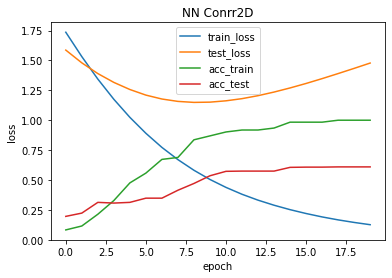

In [ ]:
# 减少batch_size
epochs = 20
lr = 0.001
batch_size = 128
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 2, 3, stride=2, dilation=1),
    nn.BatchNorm2d(2),
    nn.ReLU(),
    nn.Conv2d(2, 4, 3, dilation=2, stride=2),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.Conv2d(4, 8, 3, dilation=5),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8 * 16, 25), nn.ReLU(),
    nn.Linear(25, 3)).cuda()

optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

通过对比可以发现，batch_size的减小，模型的收敛变慢，我们epoch调整到20轮，最终的效果发现，test_acc有些许增加，但是过拟合现象依然存在。

# 三、 残差网络实验

以下部分在colab中完成

In [ ]:
!unzip vehicle_dataset.zip

/content


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride_=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride_, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.shortcut = nn.Sequential()
        if stride_ != 1 or in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride_, bias=False),
                nn.BatchNorm2d(out_channel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = nn.ReLU().forward(out)
        return out

epochs 1 train_loss 1.2206 test_loss 12.1755 train_acc 0.1967 test_acc 0.6979 time_cost 2.5123
epochs 2 train_loss 0.0000 test_loss 15.1892 train_acc 1.0000 test_acc 0.6979 time_cost 1.4087
epochs 3 train_loss 0.0000 test_loss 17.0038 train_acc 1.0000 test_acc 0.6979 time_cost 1.3911
epochs 4 train_loss 0.0000 test_loss 18.3773 train_acc 1.0000 test_acc 0.6979 time_cost 1.3973
epochs 5 train_loss 0.0000 test_loss 19.5043 train_acc 1.0000 test_acc 0.6979 time_cost 1.3868


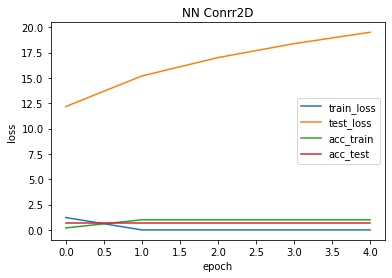

In [ ]:
epochs = 5
lr = 0.001
batch_size = 128
loss = nn.CrossEntropyLoss(reduction="none").cuda()
net = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 128, stride_=2),
    ResidualBlock(128, 128),
    ResidualBlock(128, 256, stride_=2),
    ResidualBlock(256, 256),
    ResidualBlock(256, 512, stride_=2),
    ResidualBlock(512, 512),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(512 * 16, 3)).cuda()
train_dataset = MyDateset(train_data, train_labels, transform)
test_dataset = MyDateset(test_data, test_labels, transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
optimizer = torch.optim.Adam(net.parameters(), lr)
train_corr2d(net, loss, train_loader, test_loader, epochs, optimizer, "NN Conrr2D")

最后的残差网络需要的显存过大，本地GPU资源不足，遂转移到Colab中完成。
可以看出，残差网路实验的要求是完成得很好的。但是，对于模型效果来说，过拟合现象还是比较严重的。这也是三个分实验的共性问题。

# 实验心得
1. 本次实验最大的收获在于手动实现了卷积层，虽然使用的是for循环进行，但对于整体原理把握还是比较好的。特别是，卷积层的四个维度计算分成三个函数进行编写，对于这样的代码分解，本人学习到了很多。
2. 还学习到了自定义数据集的加载和loader的定义，完成了一次CNN的全过程实验，有利于对整体实验流程的把握。